In [27]:
import pandas as pd
from bio_curve_fit.logistic import FourPLLogistic
from bio_curve_fit.plotting import plot_standard_curve 
import io

# Fitting a Four-Parameter Logistic Model to Create a Standard Curve using `bio-curve-fit`

Suppose we have some standard samples with a known concentration of some analyte, and we've tested these standards on some instrument and recorded the observed response signal. 

In [28]:
standard_curve_csv = """
known_concentration,instrument_response
348.0,216993
87.0,61126
21.75,15320
5.4375,3960
1.359375,1127
0.33984375,500
0.0849609375,411
0.021240234375,350
0.0,440
348.0,220711
87.0,58840
21.75,13650
5.4375,3600
1.359375,1150
0.33984375,580
0.0849609375,410
0.021240234375,390
0.0,461
"""

df = pd.read_csv(io.StringIO(standard_curve_csv))
df

,known_concentration,instrument_response
0,348.000000,216993
1,87.000000,61126
2,21.750000,15320
3,5.437500,3960
4,1.359375,1127
5,0.339844,500
6,0.084961,411
7,0.021240,350
8,0.000000,440
9,348.000000,220711


<Axes: xlabel='known_concentration', ylabel='instrument_response'>

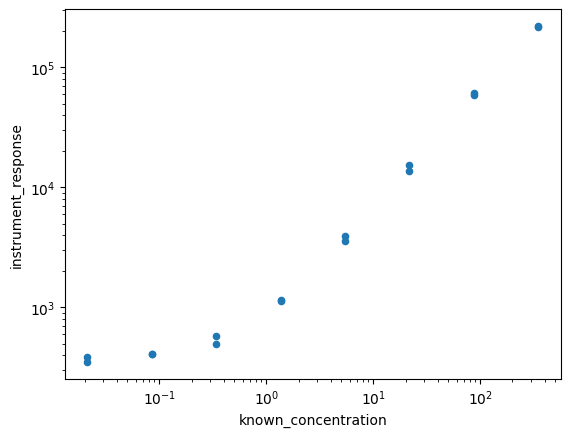

In [29]:
df.plot.scatter(x="known_concentration", y="instrument_response", logx=True, logy=True)

Note the standards have been tested in duplicate in 4:1 serial dilutions. 

Now we'd like to fit a standard curve to these data to estimate the concentration of an unknown sample given its observed response signal. Per the plot, we clearly need a non-linear model to fit the data.

To do this, we'll use the `bio-curve-fit` package to fit a four-parameter logistic model to the data. The four-parameter logistic model is commonly used to fit dose-response data, and is defined as:

$$f(x) = \frac{A-D}{1+\left(\frac{x}{C}\right)^B}+D$$

`bio-curve-fit` will find the values for the parameters $A$, $B$, $C$, and $D$ that best fit the example data above.

In [30]:
# instantiate a model object
model = FourPLLogistic()

x = df["known_concentration"]
y = df["instrument_response"]


# fit the model using the data
model.fit(x, y)
model

FourPLLogistic(A=407.9656904058429, B=1.0713507374783195, C=1139.4508608333288,
               D=997268.108428393)

The model has been fit to the data, and the best-fit parameters are visible above. They can also be accessed individually:

In [31]:
model.A_

407.9656904058429

Since `bio-curve-fit` conforms with the scikit-learn API, we can easily check the $R^2$ using the `score()` method:

In [32]:
model.score(x, y)

0.9998676357610702

The model fit also calculates upper and lower limits of detection:

In [33]:
print("Lower Limit of Detection: ", model.LLOD_)
print("Upper Limit of Detection: ", model.ULOD_)

Lower Limit of Detection:  0.1698812720922227
Upper Limit of Detection:  348.0


The default methodology is to use a value 2.5 standard deviations above the fitted curve as the lower limit of detection (where "standard deviation" is the standard deviation of the the lowest concentration standard replicates). The upper limit of detection is calculated as the highest concentration standard.

> Note: You can create your own methodology for calculating the LODs by passing a custom LOD function function into the `fit()` method. See [the code](../../bio_curve_fit/logistic.py) for more details.

Finally, let's plot the data and the fitted model:

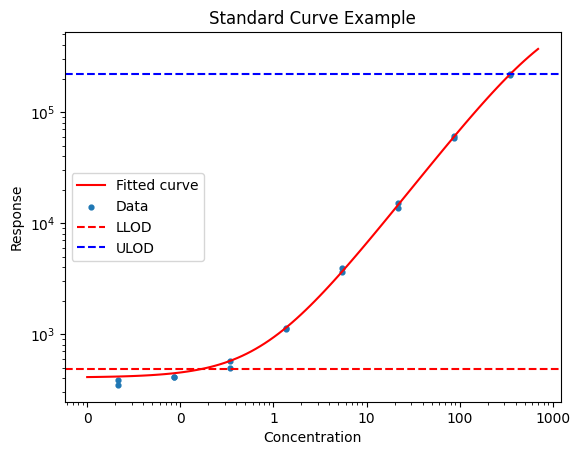

<Figure size 640x480 with 0 Axes>

In [34]:
plot_image_bytes = plot_standard_curve(x, y, model, title=f"Standard Curve Example", show_plot=True)

# save the image to a file
with open("plot.png", "wb") as f:
    f.write(plot_image_bytes)

The fit looks pretty good, but seems to be overshooting the data at the lower concentrations. 


 Let's try fitting the model again, but this time with a weighting function that is commonly used to account for heteroskedasticity that is common in dose-response data that varies over several orders of magnitude.

The model below uses the built-in `inverse_variance_weight_function` which implements an inverse-variance residual weighting function $(1/y^2)$. You can also pass in your own custom weighting functions.

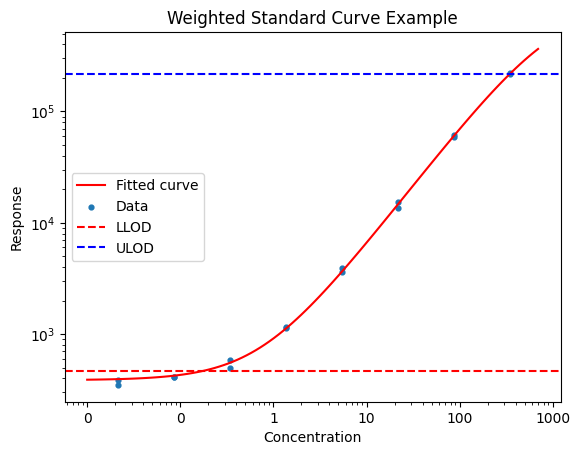

<Figure size 640x480 with 0 Axes>

In [35]:
model2 = FourPLLogistic()
model2.fit(
    x, 
    y,         
    weight_func=FourPLLogistic.inverse_variance_weight_function
)

image_bytes = plot_standard_curve(x, y, model2, title=f"Weighted Standard Curve Example", show_plot=True)

The fit looks even better now! Let's use the fitted model to calculate the concentration of unknown samples given their measured instrument responses:

In [36]:
newly_measured_responses = [400, 500, 2000, 10_000, 20_000]
model2.predict_inverse(newly_measured_responses)

array([ 0.03384359,  0.23957172,  2.82759998, 15.00047935, 29.42389068])

Note that we use the `predict_inverse()` function because we are predicting the concentration of the unknown samples from the measured signal. I.e. given the plots above, we've measured new values of $y$ (instrument response) and want to predict the corresponding values of $x$ (analyte concentration).

TODO: add colab link once repo is published